In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, interact_manual, IntSlider
import ipywidgets as widgets
import arrow

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations();

In [2]:
def sfun(x):
    return all([ ("Forsa Hartmoor" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T;

In [3]:
motor = fleet.iloc[3]
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success;

In [4]:
e=Engine.from_fleet(mp,motor)
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=datetime.now(), frompickle=True, successtime=600)
fsm.run1(enforce=False) # run Finite State Machine
fsm.store()
fsm.result;

In [5]:
rdf = fsm.result
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 71, Successful: 58, Failed: 13 => 81.7%


In [6]:
rda[filterFSM.run2filter_content];

In [7]:
# %load_ext autoreload
# %aimport -pandas, -numpy
# %autoreload 2
# Execute FSM Run 2
rda = fsm.run2(rda)
fsm.store()

FSM Run2: 100%|██████████████████████████| 71/71 [00:00<00:00, 7255.34 starts/s]


In [8]:
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb = rda
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,startpreparation,hochlauf,idle,synchronize,loadramp,maxload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,71.00,67.00,60.00,60.00,60.00,71.00,60.00,71.00,59.00,59.00,59.00,59.00
mean,111.04,22.09,4.90,19.59,146.76,4335.67,0.73,280.37,10494.74,140.10,353.09,48.98
std,74.32,3.57,0.71,15.16,69.74,810.88,0.12,90.71,10399.80,94.03,2635.36,0.31
min,60.54,17.36,4.04,1.11,105.11,0.00,0.15,109.26,4.04,106.16,9.90,48.25
25%,96.32,19.93,4.34,4.44,127.54,4493.03,0.69,277.78,2875.40,127.33,9.99,48.75
50%,98.52,21.60,4.64,11.76,135.23,4501.35,0.74,279.55,8118.00,127.40,9.99,48.92
75%,100.58,23.90,5.44,35.20,144.45,4508.00,0.78,281.12,15023.92,127.52,10.00,49.21
max,489.45,44.01,6.37,42.48,654.25,4533.00,0.95,792.87,61824.24,848.87,20252.54,49.65


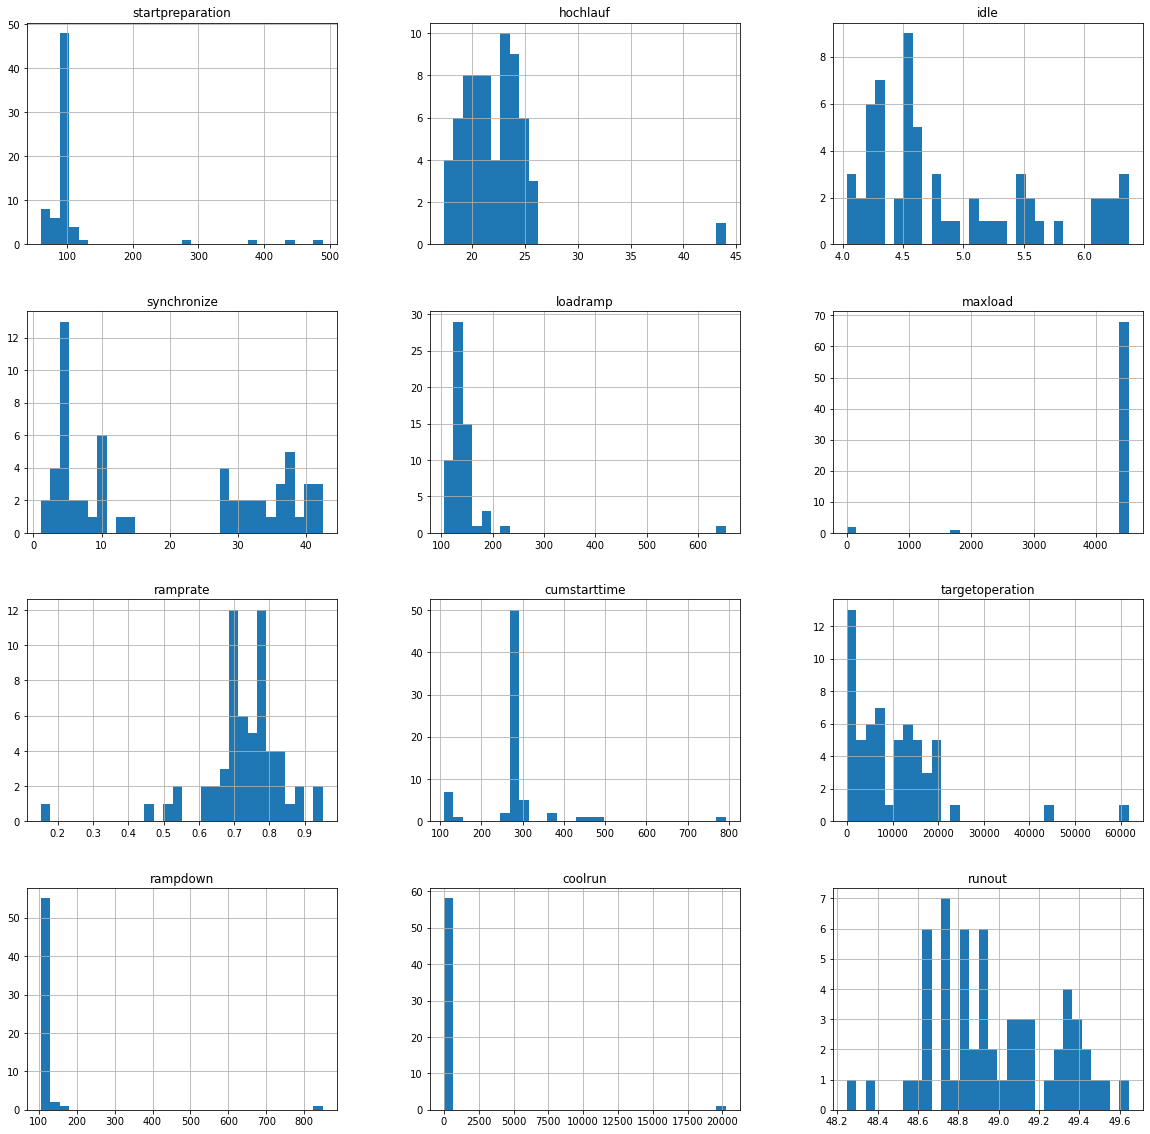

In [9]:
vec = ['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2));

In [24]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (16,8)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)
del(fig)

In [11]:
vset = ['Various_Values_SpeedAct','Power_PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    #{'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    #{'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'ylim': [0, 110], 'color':'#2171b5'}
]


In [12]:
def plot_with_additional_results(
        startversuch, 
        vset=None, 
        dset = [
        {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
        {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'}
    ]):

    if vset == None:
        vset = []
        for rec in dset:
            for d in rec['col']:
                vset.append(d) 
        vset = list(set(vset))

    data = get_cycle_data2(fsm, startversuch, max_length=None, min_length=None, cycletime=1, silent=False, p_data=vset)
    fig = FSMPlot_Start(fsm, startversuch, data, vset, dset, figsize=dfigsize); 
    #fsm run 2 results
    lcol='blue'
    pl, _ = detect_edge_left(data, 'Power_PowerAct', startversuch)
    pr, _ = detect_edge_right(data, 'Power_PowerAct', startversuch)
    sl, _ = detect_edge_left(data, 'Various_Values_SpeedAct', startversuch)
    sr, _ = detect_edge_right(data, 'Various_Values_SpeedAct', startversuch)
    add_dbokeh_vlines([sl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    add_dbokeh_vlines([sr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    add_dbokeh_vlines([pl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    add_dbokeh_vlines([pr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)

    #new_lines = [startversuch['starttime']] + [startversuch[k] for k in startversuch.keys() if k.endswith('_time')]
    #add_dbokeh_vlines(new_lines,fig,line_color='green', line_dash='solid', line_alpha=0.4)
    bokeh_show(fig)
    del(fig)

In [36]:
s = '''
<style>
    table, td, th {
        border: 1px solid grey;
        border-collapse: collapse;
        padding: 5px;
    }
    tfoot {
        text-align: left;
    }
</style>
'''

In [41]:
display(HTML(s + rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2).to_html(escape=False, index=False, na_rep='', decimal='.')))

HTML(value='\n    <style>\n        table, \n        td,\n        th {\n            border: 1px solid grey;\n  …

In [14]:
def f(x=0):
    global v; v = x; 
    startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
    plot_with_additional_results(startversuch, vset, dset) 
interact_manual(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='40%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='70%'), max=70), Button(descript…

In [ ]:
#startversuch = rdb.iloc[v]; plot_with_additional_results(startversuch, vset, dset) 

In [16]:
# startversuch = rdb.iloc[v]
# display(HTML(pd.DataFrame.from_dict(dict(zip(filterFSM.vertical_lines_times, states_lines(startversuch))), orient='index').T.to_html(escape=False,index=False)))
# td = {
#     'start': [v for k,v in startversuch['timing'].items() if k.startswith('start_')],
#     'end': [v for k,v in startversuch['timing'].items() if k.startswith('end_')]
# }
# columns = [k[4:] for k in startversuch['timing'].keys() if k.startswith('end_')]
# #display(HTML(pd.DataFrame.from_dict(td,orient='index').T.to_html(escape=False,index=False)))
# pd.DataFrame.from_dict(td,orient='index', columns=columns)

In [18]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 100
_txt = ''
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        _txt += f"<h3>Startversuch: {i}, Success: {c['success']}</h3>"
        #display(HTML(f"\n<hr><h3>Startversuch: {i}, Success: {c['success']}</h3>"))
        print()
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt += f"{ct2} {c['mode']:15} {a['state']:20} " + fsm.msgtxt(a['msg']) + "<br>"
            #_txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            #if ct2 >= mini and ct2 <= maxi:
                #fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                #plt.show()
            ct2 += 1
_txt = f"<h2>{fsm._e}, <br>{ct:3} start(s) with alarm message(s)</h2>" + _txt
display(HTML(_txt))


HTML(value='<h2>1486174 Forsa Hartmoor M04, <br>  1 not successful starts</h2><h3>Startversuch: 45, Success: F…

In [19]:
phases = [['startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation','coolrun'],'startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation','coolrun']
for phase in phases:
    al = alarms_pareto(fsm, phase)
    if not al.empty:
        display(HTML(f"<h3>{phase}:</h3>"))
        al.sort_values(by = "anz",ascending=True)
        display(HTML(al.to_html(escape=False, index=False)))

HTML(value="<h3>['startpreparation', 'starter', 'hochlauf', 'idle', 'synchronize', 'loadramp', 'targetoperatio…

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>an…

HTML(value='<h3>targetoperation:</h3>')

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>an…

HTML(value='<h3>coolrun:</h3>')

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>an…

In [20]:
for phase in phases:
    wr = warnings_pareto(fsm, phase)
    if not wr.empty:
        display(HTML(f"<h3>{phase}:</h3>"))
        wr.sort_values(by = "anz",ascending=True)
        display(HTML(wr.to_html(escape=False, index=False)))

HTML(value="<h3>['startpreparation', 'starter', 'hochlauf', 'idle', 'synchronize', 'loadramp', 'targetoperatio…

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>an…

HTML(value='<h3>loadramp:</h3>')

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>an…

HTML(value='<h3>targetoperation:</h3>')

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>an…

HTML(value='<h3>coolrun:</h3>')

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>an…

In [21]:
display(HTML(pd.DataFrame(fsm._runlog).to_html(escape=False, index=False)))

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n    </tr>\n …

In [23]:
fsm._runlog

[]

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

In [ ]:
from dmyplant2 import FSM
FSM.dot(e._fname + 'FSM.dot')

In [ ]:
# lfn = e._fname + '_runlog.txt'
# fsm.save_runlog(lfn)
# print(lfn)